In [1]:
import os
import pandas as pd
import glob
import numpy as np

from itertools import combinations

import networkx as nx
from networkx.algorithms import community

import matplotlib.pyplot as plt

from posixpath import splitext

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /gpfs/space/home/marilinm/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Script for graph csv creation (with sentiment analysis)

In [2]:
# iterating to create the graph csv-s for all the dates - 9./10/11.08 and 11/12/13.05 
# use GPU if you want to run this, elsewise, it is likely that the 13.05 data will kill the kernel

for i, file in enumerate(["../Data/conversations_2018-08-09.csv", "../Data/conversations_2018-08-10.csv", "../Data/conversations_2018-08-11.csv", "../Data/conversations_2019-05-11.csv", "../Data/conversations_2019-05-12.csv", "../Data/conversations_2019-05-13.csv"]):
    print(i)
    # user dataframe
    #a_data = pd.read_csv(files[i])
    
    # conversastions dataframe 
    data = pd.read_csv(file)
    data = data.drop(columns = "conv_indx")
      
    res = data[data.duplicated(subset=["conversation_id"], keep = False)]
    
    # selecting conversations that would create anzedge
    df_edges = (res.groupby(['conversation_id'])['userId'].apply(lambda x: pd.DataFrame(list(combinations(x,2))))
      .reset_index(level=1, drop=True)
      .reset_index())
    
    df_edges.rename(columns={0: "source", 1: "target"}, inplace = True)
    df_edges= df_edges.astype({"source":str, "target":str}, copy= True)
    
    #### creating csv-s with no sentiment analysis 

    count_df_n = df_edges.groupby(["source", "target"]).size().reset_index(name='weight')
    count_df_n.drop_duplicates()
    
    count_df_n.to_csv("graph_csv/graph_no_sent_{}.csv".format(splitext(file.split("/")[-1])[0]), index = False)

    
    #### creating csv-s with sentiment analysis - comment the following out if no sentiment is needed 
    
    # sentiment analysis prep
    tweets = res.content.values

    # classifying - if neu: 0, if pos: 2, if neg: 1 - NB! the pre-trained sentiment model 
    # does not consider emojis - de-emojifying did not help 

    lst = []

    for i in range(len(tweets)):
        if sid.polarity_scores(tweets[i])["neg"] > 0.0 and sid.polarity_scores(tweets[i])["neu"] > 0.0:
            lst.append(1) # NB! this is temporary classifying, the -1 to 1 range is provided in the sentimennt analysis part below
        elif sid.polarity_scores(tweets[i])["pos"] > 0.0 and sid.polarity_scores(tweets[i])["neu"] > 0.0:
            lst.append(2)
        else: 
            lst.append(0)

    # assigning sentiment values to the res dataframe         
    res["sentiment"] = lst

    # making a cp just in case 
    df2 = df_edges.copy(deep = True)
    df2 = df2.merge(res[["conversation_id", "userId", "sentiment"]], how = "left", left_on = "target", right_on = "userId")

    df2 = df2.drop(columns= ["conversation_id_y", "userId"])
    df2.rename(columns = {'conversation_id_x':'conversation_id'}, inplace = True)

    # now weight considers both unique connections and the same sentiment
    count_df = df2.groupby(["source", "target", "sentiment"]).size().reset_index(name='weight')

    # removing a strange artefact - where the source and target are the same 
    count_df = count_df[count_df["source"] != count_df["target"]] 
    
    # removing duplicates 
    count_df.drop_duplicates()

    # saving as csv 
    count_df.to_csv("graph_csv/graph_ver_sent_{}.csv".format(splitext(file.split("/")[-1])[0]), index = False)
   


0
1


### Finding top 20 most popular tweets during the given dates and checking the sentiment of those

In [97]:
files_a = ["graph_csv/graph_sent_conversations_2018-08-09.csv", 
         "graph_csv/graph_sent_conversations_2019-05-11.csv", 
         "graph_csv/graph_sent_conversations_2018-08-10.csv", 
         "graph_csv/graph_sent_conversations_2019-05-12.csv", 
         "graph_csv/graph_sent_conversations_2018-08-11.csv", 
         "graph_csv/graph_sent_conversations_2019-05-13.csv"]

# sum of all tweets 
summ = 0
for f in files_a: 
    print(len(pd.read_csv(f)))
    summ += len(pd.read_csv(f))
    

328913
1562986
817482
5159932
1263863
6514681


In [96]:
summ

15647857

In [2]:
files_a = ["graph_csv/graph_sent_conversations_2018-08-09.csv", 
         "graph_csv/graph_sent_conversations_2019-05-11.csv", 
         "graph_csv/graph_sent_conversations_2018-08-10.csv", 
         "graph_csv/graph_sent_conversations_2019-05-12.csv", 
         "graph_csv/graph_sent_conversations_2018-08-11.csv", 
         "graph_csv/graph_sent_conversations_2019-05-13.csv"]

top_tweets = {i:[] for i in range(6)}
avg_sent = {i:[] for i in range(6)}


for i, file in enumerate(files_a):
    
    graph = pd.read_csv(file)
    G = nx.from_pandas_edgelist(graph, source= "source", target= "target",edge_attr=True)
    
    lst = []
    for val in list(graph.sentiment): 
        if val == 1: 
            lst.append(-1)
        elif val == 2:
            lst.append(1)
            
        else: lst.append(val)
            
    graph.sentiment = np.array(lst)

    pagerank_cent = nx.pagerank(G, weight = "weight")
    
    # selecting top 20
    for node, cent in sorted(pagerank_cent.items(), key=lambda item: item[1], reverse=True)[:20]:
        top_tweets[i].append(node)
        avg_sent[i].append(graph[graph.source == node]["sentiment"].mean())
        

2019-05-11, 0.11810711081613554
2019-05-12, 0.052184246361649984
2019-05-13, 0.04159091369718131


Text(0, 0.5, 'Average sentiment')

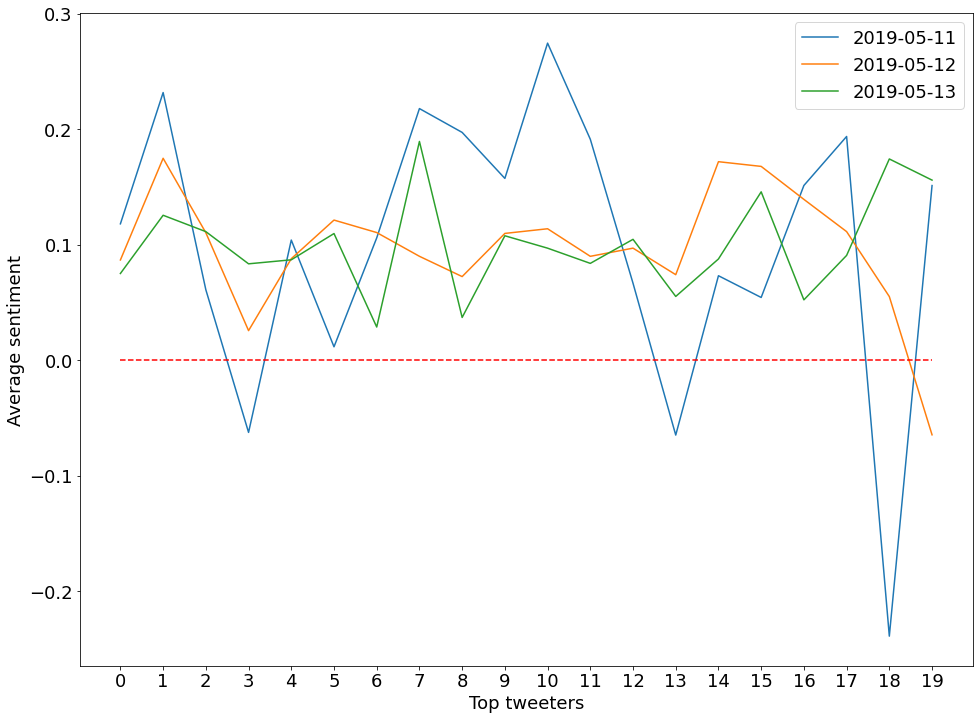

In [43]:
#fig, ax = plt.subplots(plt.figure == (16, 24))
plt.figure(figsize = (16, 12))

for i in range(1, len(avg_sent), 2):
    print(f'{splitext(files_a[i].split("_")[-1])[0]}, {np.std(avg_sent[i])}')
    plt.plot(avg_sent[i], label = splitext(files_a[i].split("_")[-1])[0])

plt.xticks(range(20), fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.hlines(y = 0.0, xmin = 0, xmax = 19, colors = "r", linestyles = "dashed")
plt.xlabel("Top tweeters", fontsize=18)
plt.ylabel("Average sentiment", fontsize=18)

2018-08-09, 0.1612466985953959
2018-08-10, 0.09640442256420055
2018-08-11, 0.06300806498188745


Text(0, 0.5, 'Average sentiment')

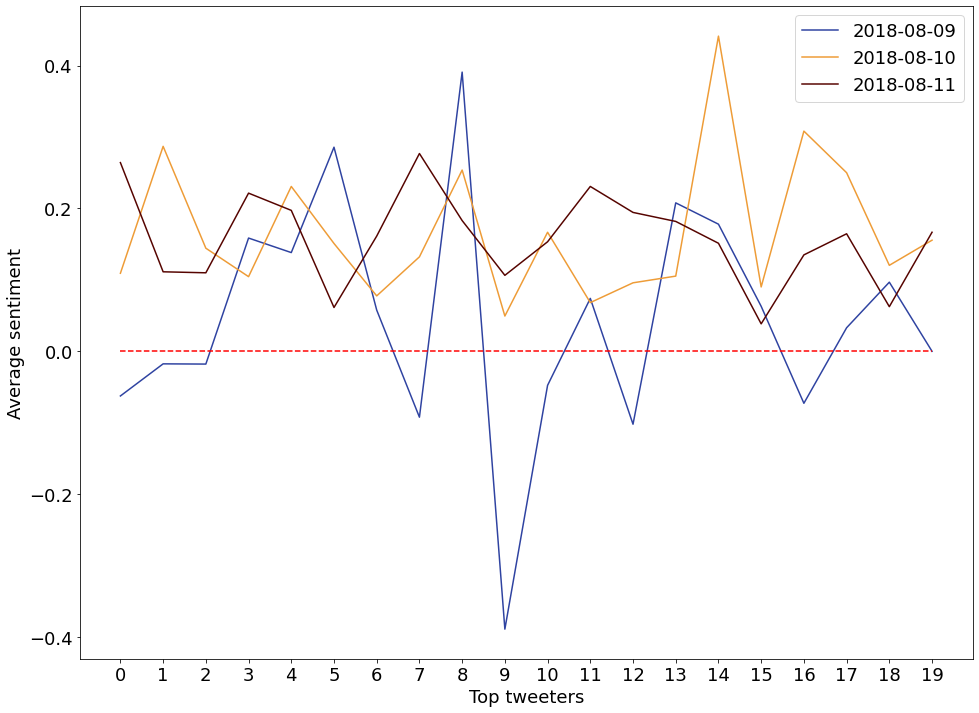

In [44]:
plt.figure(figsize = (16, 12))
colors = ["#2f43a1", "", "#ee9c37", "", "#560400", ""]
for i in range(0, len(avg_sent), 2):
    print(f'{splitext(files_a[i].split("_")[-1])[0]}, {np.std(avg_sent[i])}')
    plt.plot(avg_sent[i], label = splitext(files_a[i].split("_")[-1])[0], color = colors[i])
    
plt.xticks(range(20), fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.hlines(y = 0.0, xmin = 0, xmax = 19, colors = "r", linestyles = "dashed")
plt.xlabel("Top tweeters", fontsize=18)
plt.ylabel("Average sentiment", fontsize=18)

2018-08-09, 0.1612466985953959
2019-05-11, 0.11810711081613554
2018-08-10, 0.09640442256420055
2019-05-12, 0.052184246361649984
2018-08-11, 0.06300806498188745
2019-05-13, 0.04159091369718131


Text(0, 0.5, 'Average sentiment')

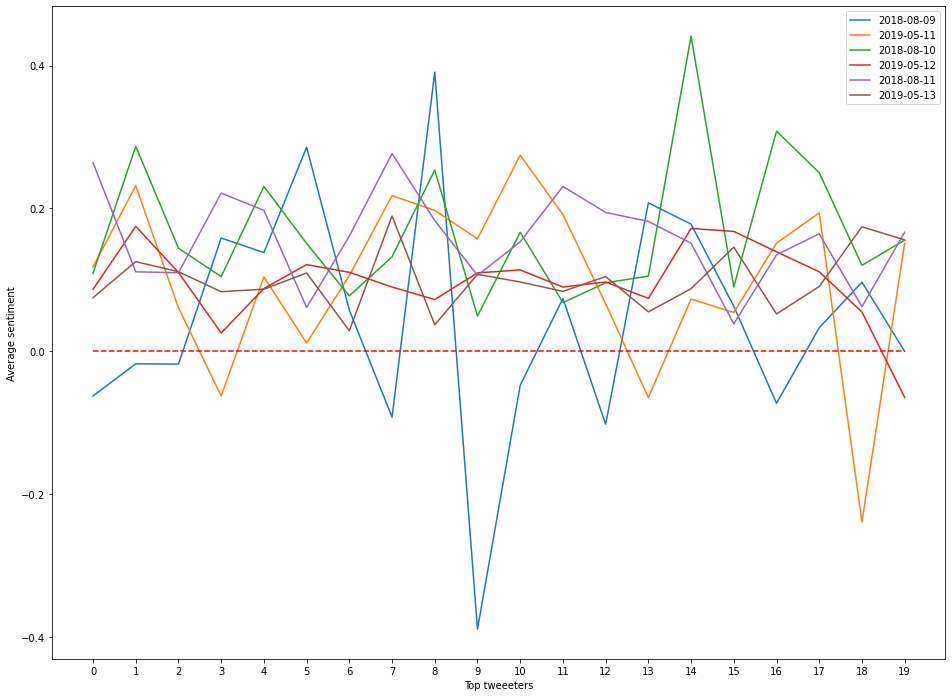

In [27]:
plt.figure(figsize = (16, 12))

for i in range(len(avg_sent)):
    print(f'{splitext(files_a[i].split("_")[-1])[0]}, {np.std(avg_sent[i])}')
    plt.plot(avg_sent[i], label = splitext(files_a[i].split("_")[-1])[0])

plt.xticks(range(20))
plt.legend()
plt.xlabel("Top tweeeters")
plt.hlines(y = 0.0, xmin = 0, xmax = 19, colors = "r", linestyles = "dashed")
plt.ylabel("Average sentiment")

### Change in activity and sentiment in top n most active repliers 

In [65]:
files = [["graph_csv/graph_sent_conversations_2018-08-09.csv", 
         "graph_csv/graph_sent_conversations_2019-05-11.csv"],
         ["graph_csv/graph_sent_conversations_2018-08-10.csv", 
         "graph_csv/graph_sent_conversations_2019-05-12.csv"], 
         ["graph_csv/graph_sent_conversations_2018-08-11.csv", 
         "graph_csv/graph_sent_conversations_2019-05-13.csv"]]

replier_df_1 = pd.DataFrame(columns = ["Date", "Respondent ID", "Nr of links", "Average sentiment", "Norm_activity"])
replier_df_2 = pd.DataFrame(columns = ["Date", "Respondent ID", "Nr of links", "Average sentiment", "Norm_activity"])
replier_df_3 = pd.DataFrame(columns = ["Date", "Respondent ID", "Nr of links", "Average sentiment", "Norm_activity"])

df_lst = [replier_df_1, replier_df_2, replier_df_3]


for j, lst in enumerate(files):
    
    #for i in range(len(lst)):
    graph = pd.read_csv(lst[0])
    G = nx.from_pandas_edgelist(graph, source= "source", target= "target",edge_attr=True)

    replier_degree = {}
    date = splitext(lst[0].split("_")[-1])[0]
    
    lst_a = []
    for val in list(graph.sentiment): 
        if val == 1: 
            lst_a.append(-1)
        elif val == 2:
            lst_a.append(1)

        else: lst_a.append(val)
            
    graph.sentiment = np.array(lst_a)
    
    # selecting top 20 repliers
    for replier in np.unique(graph.target):
        replier_degree[replier] = G.degree(replier)

    for replier, degree in sorted(replier_degree.items(), key=lambda item: item[1], reverse=True)[:100]:
        df_lst[j] = df_lst[j].append({'Date': date, 'Respondent ID': replier, 'Nr of links': degree, 'Average sentiment':graph[graph.target == replier]["sentiment"].mean(), "Norm_activity": degree/len(G.edges())}, ignore_index = True)
        
    graph_2 = pd.read_csv(lst[1])
    g2 = nx.from_pandas_edgelist(graph_2, source= "source", target= "target",edge_attr=True)
    
    lst_b = []
    
    for val in list(graph_2.sentiment): 
        if val == 1: 
            lst_b.append(-1)
        elif val == 2:
            lst_b.append(1)

        else: lst_b.append(val)
            
    graph_2.sentiment = np.array(lst_b)
    
    for resp in list(df_lst[j]["Respondent ID"]):

        try:
            df_lst[j] = df_lst[j].append({'Date': splitext(lst[1].split("_")[-1])[0], 'Respondent ID': resp, 'Nr of links': g2.degree(resp), \
                                            'Average sentiment':graph_2[graph_2.target == resp]["sentiment"].mean(), "Norm_activity": g2.degree(resp)/len(g2.edges())}, ignore_index = True)
        except:
            df_lst[j] = df_lst[j].append({'Date': splitext(lst[1].split("_")[-1])[0], 'Respondent ID': resp, 'Nr of links': 0, \
                                            'Average sentiment':np.nan, "Norm_activity": 0}, ignore_index = True)


In [98]:
assert(len(df_lst[0]) == len(df_lst[1]) == len(df_lst[2]))

In [118]:
# saving the dataframes just in case
df_lst[0].to_csv("df1.csv", index = False, header = True)
df_lst[1].to_csv("df2.csv", index = False, header = True)
df_lst[2].to_csv("df3.csv", index = False, header = True)

In [148]:
# saving change in activity and sentiment for plotting
akt_muutus = {i:[] for i in range(3)}
sent_muutus = {i:[] for i in range(3)}
deg_muutus = {i:[] for i in range(3)}

for m, file in enumerate(["df1.csv", "df2.csv", "df3.csv"]):

    dat = pd.read_csv(file)
    

    mkm = dat[dat["Average sentiment"].isnull()].index.tolist()

    dat_c = pd.DataFrame(columns = dat.columns)

    for idx in mkm:
        dats = dat[dat["Respondent ID"] ==  dat.iloc[idx]["Respondent ID"]]
        dat_c = pd.concat([dat_c, dats])

    D = dat.copy(deep = True)
    D1 = dat_c.copy(deep = True)
    dat = pd.DataFrame(D, index = set(D.index).difference(set(D1.index))).reset_index(drop = True)
    dat = dat.sort_values(by=["Respondent ID"]).reset_index(drop = True)


    i = 0
    for j in range(len(dat)): 
        try:
            akt_muutus[m].append(dat.iloc[i]["Norm_activity"] - dat.iloc[i + 1]["Norm_activity"])
            sent_muutus[m].append(dat.iloc[i]["Average sentiment"] - dat.iloc[i + 1]["Average sentiment"])
            deg_muutus[m].append(dat.iloc[i]["Nr of links"] - dat.iloc[i + 1]["Nr of links"])
            
            i += 2
        except: 
            continue



Text(0.5, 0, 'Top respondents')

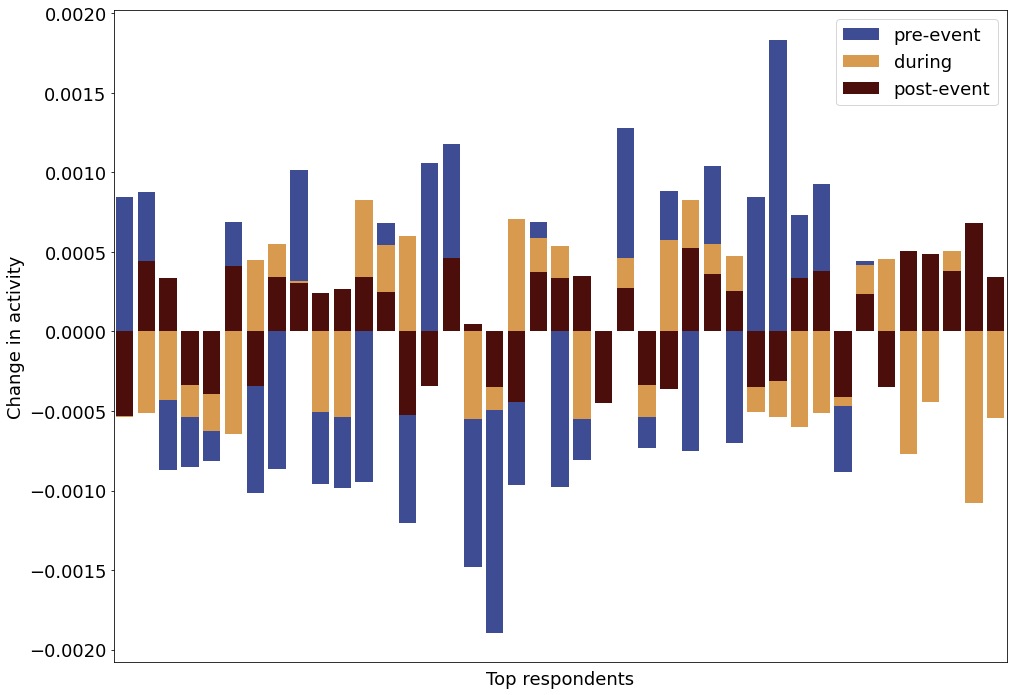

In [183]:
plt.figure(figsize = (16, 12))
colors = ["#2f43a1","#ee9c37", "#560400"]
lbls = ["pre-event", "during", "post-event"]

for i in range(len(akt_muutus)):
    ax = sns.barplot(x=np.arange(len(akt_muutus[i])), y = akt_muutus[i], label = lbls[i], color = colors[i])
    

plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.xlim(-0.5, 40.5)

plt.ylabel("Change in activity", fontsize=18)

ax.axes.xaxis.set_ticks([])
plt.xlabel("Top respondents", fontsize=18)


Text(0, 0.5, 'Change in sentiment')

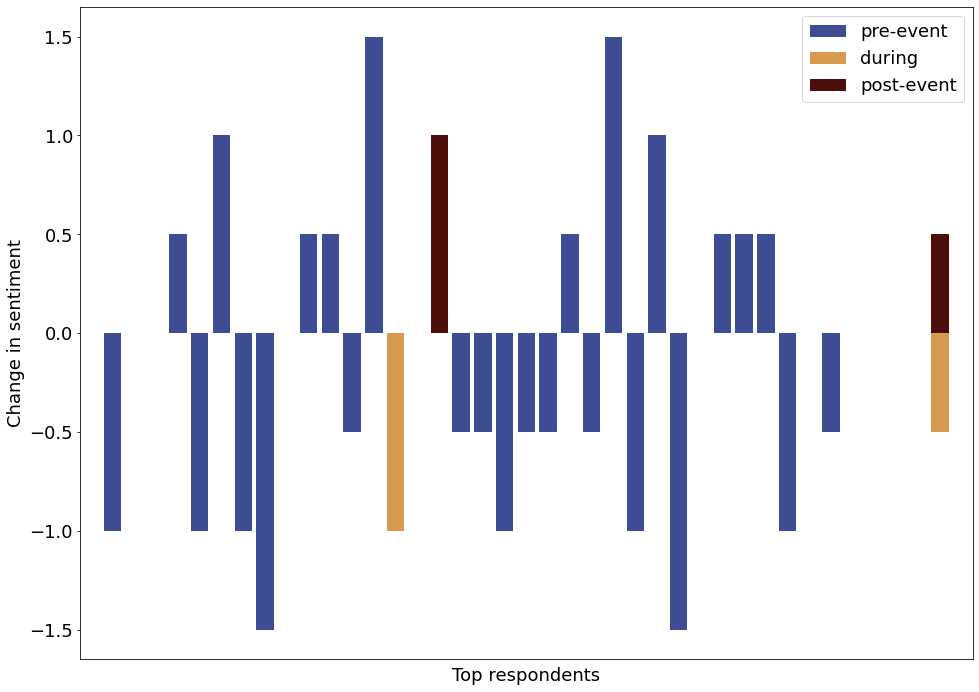

In [186]:
plt.figure(figsize = (16, 12))
colors = ["#2f43a1","#ee9c37", "#560400"]
lbls = ["pre-event", "during", "post-event"]

for i in range(len(sent_muutus)):
    ax = sns.barplot(x=np.arange(len(sent_muutus[i])), y = sent_muutus[i], label = lbls[i], color = colors[i])
    
#plt.xticks(range(20), fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.xlim(-0.5, 40.5)

ax.axes.xaxis.set_ticks([])
plt.xlabel("Top respondents", fontsize=18)

#plt.hlines(y = 0.0, xmin = 0, xmax = 19, colors = "r", linestyles = "dashed")
#plt.xlabel("Top tweeters", fontsize=18)
plt.ylabel("Change in sentiment", fontsize=18)

### Example of network descriptive analysis

In [141]:
# helper functions from the lab 
def net_prop_dict(G):
    prop_dict = {}

    prop_dict['no_of_nodes'] = nx.number_of_nodes(G)
    prop_dict['no_of_edges'] = nx.number_of_edges(G)
    if nx.is_connected(G):
        prop_dict['average_shortest_path_length'] = nx.average_shortest_path_length(G)
        prop_dict['diameter'] = nx.diameter(G)
    prop_dict['transitivity'] = nx.transitivity(G)
    prop_dict['average_clustering'] = nx.average_clustering(G)   
    prop_dict['edge_density'] = nx.classes.function.density(G)
    prop_dict['average_degree'] = np.array([d for n, d in G.degree()]).sum()/nx.number_of_nodes(G)
    prop_dict['total_triangles'] = np.array(list(nx.triangles(G).values())).sum()
    prop_dict['number_connected_components'] = nx.algorithms.components.number_connected_components(G)
    return prop_dict

def net_prop_dict_whole(G, k):
    prop_dict = {}

    prop_dict['no_of_nodes'] = nx.number_of_nodes(G)
    prop_dict['no_of_edges'] = nx.number_of_edges(G)
    if nx.is_connected(G):
        prop_dict['average_shortest_path_length'] = nx.average_shortest_path_length(G)
        prop_dict['diameter'] = nx.diameter(G)
    prop_dict['transitivity'] = nx.transitivity(G)
    prop_dict['average_clustering'] = nx.average_clustering(G)   
    prop_dict['edge_density'] = nx.classes.function.density(G)
    prop_dict['average_degree'] = np.array([d for n, d in G.degree()]).sum()/nx.number_of_nodes(G)
    prop_dict['total_triangles'] = np.array(list(nx.triangles(G).values())).sum()
    prop_dict['number_connected_components'] = nx.algorithms.components.number_connected_components(G)
    prop_dict['giant_component_prop'] = net_prop_dict(G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0]))
    prop_dict['k_core_prop'] = net_prop_dict(nx.k_core(G))
    return prop_dict

In [ ]:
# takes a lof time 
net_prop_dict_whole(G, 3)

(array([7.66e+03, 1.60e+03, 7.00e+02, 8.10e+02, 2.47e+02, 3.50e+01,
        8.00e+00, 2.00e+00, 1.00e+00, 3.00e+00]),
 array([  1. ,  48.4,  95.8, 143.2, 190.6, 238. , 285.4, 332.8, 380.2,
        427.6, 475. ]),
 <a list of 10 Patch objects>)

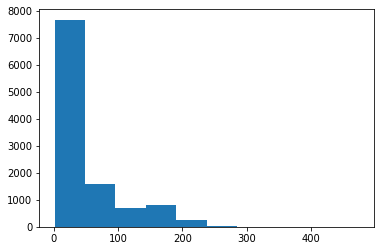

In [16]:
# degree histogram
degrees = [G.degree(n) for n in G.nodes()]
plt.hist(degrees)

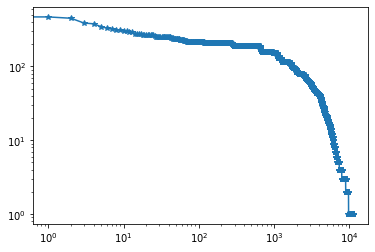

In [17]:
# degree distribution log-log
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
plt.loglog(degree_sequence,marker='*')
plt.show()

In [ ]:
# centrality 
eigen_cent = nx.eigenvector_centrality(G)

#pagerank_cent = nx.pagerank(G)
#betweenness = nx.betweenbness_centrality(G)

In [158]:
pagerank_cent = nx.pagerank(G)

In [159]:
print("eigen:")
for i in sorted(eigen_cent.items(), key=lambda item: item[1], reverse=True)[:3]:
  print(i)

#print("--")
print("pagerank:")
for i in sorted(pagerank_cent.items(), key=lambda item: item[1], reverse=True)[:3]:
  print(i)

#print("--")
# print("betweenness")
# for i in sorted(betweenness.items(), key=lambda item: item[1], reverse=True)[:3]:
#   print(i)

eigen:
('2987868107', 0.06985349684966168)
('2955389859', 0.06960752703955658)
('4870741240', 0.06914188412174209)
pagerank:
('4604001507', 0.0015631443172323491)
('2665988107', 0.001340544347697076)
('41224886', 0.001077410164717)


In [144]:
degree_centrality = nx.degree_centrality(G) # outputs id: degree of centrality
#nodes[nodes["id"].isin([idx for (idx, val) in sorted(degree_centrality.items(), key=lambda item: item[1], reverse = True)[:4]])]["Name"]

In [145]:
sorted(degree_centrality.items(), key=lambda item: item[1], reverse = True)[:5] # user-ids which have more de

[('3099075032', 0.04292815183009489),
 ('973077014633730048', 0.04229552643470402),
 ('108568373', 0.040578400361500226),
 ('1561123663', 0.03488477180298238),
 ('2987868107', 0.034161771351107095)]

In [154]:
# community algorithms 
import community.community_louvain as community_louvain
import numpy as np

lst_m = community_louvain.best_partition(G)
np.unique(list(lst_m.values())) # number of communities

array([   0,    1,    2, ..., 1633, 1634, 1635])

In [25]:
# network analysis
D = nx.from_pandas_edgelist(pd.read_csv("graph_conversations_2018-08-09.csv"), source= "source", target= "target",edge_attr=True) # nx.graph() 

eigen_cent = nx.eigenvector_centrality(D)
pagerank_cent = nx.pagerank(D)
#betweenness = nx.betweenness_centrality(D)


# Number of nodes
print("Number of nodes:", D.number_of_nodes())

# Number of edges
print("Number of edges:", D.number_of_edges())

# Average degree centrality
avg_degree = 2*D.number_of_edges() / float(D.number_of_nodes())
print("Average degree centrality:", avg_degree)

density = nx.density(D)
print("Density:", density)

eigen = np.mean(np.array(list([eigen_cent[i] for i in eigen_cent])))
print("Eigenvector centrality:", eigen)

pagerank = np.mean(np.array(list([pagerank_cent[i] for i in pagerank_cent])))
print("PageRank centrality:", pagerank)

#betweenness = np.mean(np.array(list([betweenness[i] for i in betweenness])))
#print("Betweenness centrality:", betweenness)

Number of nodes: 11066
Number of edges: 241970
Average degree centrality: 43.732152539309595
Density: 0.003952295755924953
Eigenvector centrality: 0.0013401645795401496
PageRank centrality: 9.036688957166094e-05


## Testing arena 

In [51]:
data = pd.read_csv("../Data/conversations_2018-08-09.csv")
data = data.drop(columns = "conv_indx")

In [52]:
a_data = pd.read_csv("../Data/premier_league_2018-08-09.csv")
a_data.head()

,Tweet_url,Datetime,Text,Tweet Id,Username,User_id,Description,Display_name,Verified,Created_at,...,Quote_count,Lang,Source_label,inReplyToTweetId,conversationId,Media,Coordinates,Place,Hashtags,Cashtags
0,https://twitter.com/AfifMrFive/status/10277060...,2018-08-09 23:59:59+00:00,Man Utd sengaja tdk memberikan kejutan transfe...,1027706086210469888,AfifMrFive,472843316,In the Name of Coffee,T.E.M.P.E,False,2012-01-24 10:56:02+00:00,...,0,in,Twitter for Android,NaN,1027706086210469888,NaN,NaN,NaN,NaN,NaN
1,https://twitter.com/ManoDLC/status/10277060680...,2018-08-09 23:59:55+00:00,#EsporteInterativo vai deixar saudades ❤️ Tris...,1027706068082876417,ManoDLC,730459959205502977,Flamengo até morrer eu sou! ❤️🖤,𝙊 𝙏𝙝𝙪𝙪𝙧 ᶜʳᶠ,False,2016-05-11 18:10:00+00:00,...,0,pt,Twitter for Android,NaN,1027706068082876417,NaN,NaN,NaN,['EsporteInterativo'],NaN
2,https://twitter.com/rumbonuevo/status/10277060...,2018-08-09 23:59:54+00:00,Inauguran Premier League 2018 - https://t.co/7...,1027706064295342080,rumbonuevo,125835134,"Rumbo Nuevo, El Diario de la Vida Tabasqueña, ...",Rumbo Nuevo,False,2010-03-24 01:08:02+00:00,...,0,it,app socialautopost,NaN,1027706064295342080,[Photo(previewUrl='https://pbs.twimg.com/media...,NaN,NaN,NaN,NaN
3,https://twitter.com/sportimba/status/102770606...,2018-08-09 23:59:53+00:00,Descripción gráfica de los fichajes en la #Pre...,1027706063032860672,sportimba,860314246177062912,Somos el primer portal peruano exclusivo y esp...,Sportimba.com,False,2017-05-05 02:04:35+00:00,...,0,es,Twitter for Android,NaN,1027706063032860672,[Photo(previewUrl='https://pbs.twimg.com/media...,NaN,NaN,['PremierLeague'],NaN
4,https://twitter.com/stommx/status/102770602848...,2018-08-09 23:59:45+00:00,I liked a @YouTube video https://t.co/WTIRoTzQ...,1027706028488454146,stommx,346876874,NaN,SteveW,False,2011-08-01 23:51:07+00:00,...,0,en,Google,NaN,1027706028488454146,NaN,NaN,NaN,NaN,NaN


In [53]:
data

,conversation_id,tweetId,content,userId
0,1027705841808551936,1027705841808551936,The @premierleague is back tomorrow 😍😍😍,466107707
1,1027705638401523714,1027705638401523714,©️ THE #FPL CAPTAINS POLL ©️\n\nFantasy Premie...,470018406
2,1027705638401523714,1027804676241145856,@FPL_OWLBEAR @FFPundits If I was brave enough ...,860951831777771520
3,1027705638401523714,1027709014619172866,@FFPundits Any tips? https://t.co/VJz1wRpDbO,922075763507122176
4,1027705638401523714,1027805006274224128,@MarkyHHugget @FFPundits Cedric is probably 50...,860951831777771520
...,...,...,...,...
18529,1027345571307302912,1027365112708063232,@dhautzig @BobbySoccerRep Not sure you are pla...,2275331414
18530,1027345571307302912,1027370059579228160,@AndyfromNewHamp @BobbySoccerRep Top half and ...,105629880
18531,1027344358863863808,1027344358863863808,Manchester United legend Paul #Scholes believe...,4196267478
18532,1027343704103833606,1027343704103833606,Last summer the financial power of the Premier...,521238652


In [56]:
# selecting only verified users to 
df = a_data[a_data['Verified']]
df.Verified.value_counts()
verTweets = df['Tweet Id']

In [57]:
df_conv = data[data.conversation_id.isin(verTweets)]

In [58]:
df_conv

,conversation_id,tweetId,content,userId
18,1027703139183587329,1027703139183587329,A total of 16 Argentine's will take part in th...,382431601
52,1027702123797114880,1027702123797114880,If you're still dealing with #WorldCup withdra...,27931710
53,1027702123797114880,1027704995917914112,@cbctom I can’t see anyone winning the EPL oth...,878086126552006656
54,1027702123797114880,1027705671184261120,@SiTurn62 Good assessment Simon...my Reds will...,27931710
55,1027702123797114880,1027705093892833280,@cbctom German Bundesliga won’t start for anot...,31342044
...,...,...,...,...
18520,1027347477173817346,1027347477173817346,Doing some late-night fantasy football tinkeri...,15332636
18521,1027347477173817346,1027356979105353729,@talkSPORT Are Mkhitaryan and Alisson good opt...,4353903375
18531,1027344358863863808,1027344358863863808,Manchester United legend Paul #Scholes believe...,4196267478
18532,1027343704103833606,1027343704103833606,Last summer the financial power of the Premier...,521238652


In [66]:
# selecting conversations that would create an edge
res = df_conv[df_conv.duplicated(subset=["conversation_id"], keep =False)]

In [67]:
res.head()

,conversation_id,tweetId,content,userId
52,1027702123797114880,1027702123797114880,If you're still dealing with #WorldCup withdra...,27931710
53,1027702123797114880,1027704995917914112,@cbctom I can’t see anyone winning the EPL oth...,878086126552006656
54,1027702123797114880,1027705671184261120,@SiTurn62 Good assessment Simon...my Reds will...,27931710
55,1027702123797114880,1027705093892833280,@cbctom German Bundesliga won’t start for anot...,31342044
56,1027702123797114880,1027705945315364864,@cbctom My son is so excited for it to start. ...,3310537599


In [68]:
len(res)

7506

In [ ]:
df_links.rename(columns={0: "source", 1: "target"}, inplace = True)
df_edges= df_links.astype({"source":str, "target":str}, copy= True)

count_df = df_edges.groupby(["source", "target"]).size().reset_index(name='weight')

In [8]:
# text data from the dataset 
tweets = res.content.values

In [9]:
tweets[95]

'Back in the win column. Nice to end someone else’s winning streak too. Good to have @richarlison97 back as well. On to next week😎 https://t.co/yvFRTi8gqI'

In [10]:
# using a pre-trained sentiment classifier
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer


sid = SentimentIntensityAnalyzer()
sid.polarity_scores(tweets[96])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/marilin/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


{'neg': 0.0, 'neu': 0.886, 'pos': 0.114, 'compound': 0.5927}

In [11]:
# classifying - if neu: 0, if pos: 2, if neg: 1
lst = []
for i in range(len(tweets)):
    if sid.polarity_scores(tweets[i])["neg"] > 0.0 and sid.polarity_scores(tweets[i])["neu"] > 0.0:
        lst.append(1)
    elif sid.polarity_scores(tweets[i])["pos"] > 0.0 and sid.polarity_scores(tweets[i])["neu"] > 0.0:
        lst.append(2)
    else: 
        lst.append(0)
    

In [13]:
res["sentiment"] = lst

/tmp/ipykernel_44701/1405345047.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res["sentiment"] = lst


In [14]:
res.head()

,conversation_id,tweetId,content,userId,sentiment
1,1027705638401523714,1027705638401523714,©️ THE #FPL CAPTAINS POLL ©️\n\nFantasy Premie...,470018406,0
2,1027705638401523714,1027804676241145856,@FPL_OWLBEAR @FFPundits If I was brave enough ...,860951831777771520,2
3,1027705638401523714,1027709014619172866,@FFPundits Any tips? https://t.co/VJz1wRpDbO,922075763507122176,0
4,1027705638401523714,1027805006274224128,@MarkyHHugget @FFPundits Cedric is probably 50...,860951831777771520,0
5,1027705638401523714,1027806698424213504,@FFPundits_Drew @FPL_OWLBEAR Same!,470018406,0


In [50]:
res[(res.userId == 470018406) & (res.conversation_id == 1027705638401523714)]

,conversation_id,tweetId,content,userId,sentiment
1,1027705638401523714,1027705638401523714,©️ THE #FPL CAPTAINS POLL ©️\n\nFantasy Premie...,470018406,0
5,1027705638401523714,1027806698424213504,@FFPundits_Drew @FPL_OWLBEAR Same!,470018406,0


In [ ]:
df_links = (res.groupby(['conversation_id'])['userId'].apply(lambda x: pd.DataFrame(list(combinations(x,2))))
      .reset_index(level=1, drop=True)
      .reset_index())

In [26]:
df2 = res.groupby(["conversation_id", "userId"])["sentiment"].sum().reset_index()
df2.head()

,conversation_id,userId,sentiment
0,1027275106458976256,196442913,6
1,1027275106458976256,299263920,2
2,1027275106458976256,364852345,1
3,1027275106458976256,729714363637084160,2
4,1027275106458976256,865239626163859456,13


In [15]:
df_links = (res.groupby(['conversation_id'])['userId'].apply(lambda x: pd.DataFrame(list(combinations(x,2))))
      .reset_index(level=1, drop=True)
      .reset_index())

df_links.rename(columns={0: "source", 1: "target"}, inplace = True)
df_edges= df_links.astype({"source":str, "target":str}, copy= True)


In [ ]:
count_df.to_csv("graph1_08_09.csv", index = False)

### testing for sentiment analysis 

In [16]:
df_links.head()

,conversation_id,source,target
0,1027275106458976256,299263920,1027461210353135616
1,1027275106458976256,299263920,364852345
2,1027275106458976256,299263920,948683826313809925
3,1027275106458976256,299263920,865239626163859456
4,1027275106458976256,299263920,1027461210353135616


In [36]:
df2 = df_links.copy(deep = True)
df2 = df2.merge(res[["conversation_id", "userId", "sentiment"]], how = "left", left_on = "target", right_on = "userId")
df2.head()

,conversation_id_x,source,target,conversation_id_y,userId,sentiment
0,1027275106458976256,299263920,1027461210353135616,1027275106458976256,1027461210353135616,1
1,1027275106458976256,299263920,1027461210353135616,1027275106458976256,1027461210353135616,1
2,1027275106458976256,299263920,1027461210353135616,1027275106458976256,1027461210353135616,1
3,1027275106458976256,299263920,1027461210353135616,1027275106458976256,1027461210353135616,1
4,1027275106458976256,299263920,1027461210353135616,1027275106458976256,1027461210353135616,1


In [37]:
df2 = df2.drop(columns= ["conversation_id_y", "userId"])

In [38]:
df2.rename(columns = {'conversation_id_x':'conversation_id'}, inplace = True)

In [55]:
# now weight assumes both mutliple connections and the same sentiment
count_df = df2.groupby(["source", "target", "sentiment"]).size().reset_index(name='weight')

In [57]:
# removing rows where the source and target are the same 
count_df = count_df[count_df["source"] != count_df["target"]]
count_df

,source,target,sentiment,weight
2,58123,1533467245,0,6
3,58123,2474568204,0,4
4,58123,736726365534179328,1,2
5,783931,25719315,1,6
6,783931,35705804,0,1
...,...,...,...,...
333395,1421584162935431168,943550046745780227,1,10
333396,1421584162935431168,943550046745780227,2,20
333397,1421584162935431168,1004860303199399937,0,14
333398,1421584162935431168,1004860303199399937,1,14
